In [462]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from graphviz import Digraph (done below)
#import torch (done below)
#import random (done below)

In [463]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #grad represents derivative of L with respect to current value, we initialize it at 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})(label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) #make sure other is an int or a float, since if other is a Value then the derivative operation would be different
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): #for when other * self (in case its int * Value)
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        #sets gradients (of all children) by sorting nodes and calling _backward on them in order

        #implementing topological sort (creates a list of nodes in order from first to last)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        #remember to set gradient of final node to 1.0 to start (or all child gradients will be 0)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


In [464]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)(label=)

In [465]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the grain, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [466]:
##using tanh function

#modeling a single 'neuron'
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b') #arbitrary bias value karpathy picked
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'


In [467]:
##using exp, sub, and neg functions

#modeling a single 'neuron'
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b') #arbitrary bias value karpathy picked
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = ((n*2).exp() - 1) / ((n*2).exp() + 1)
o.label = 'o'

In [468]:
#setting gradients by sorting nodes and calling _backward on them in order
o.backward()

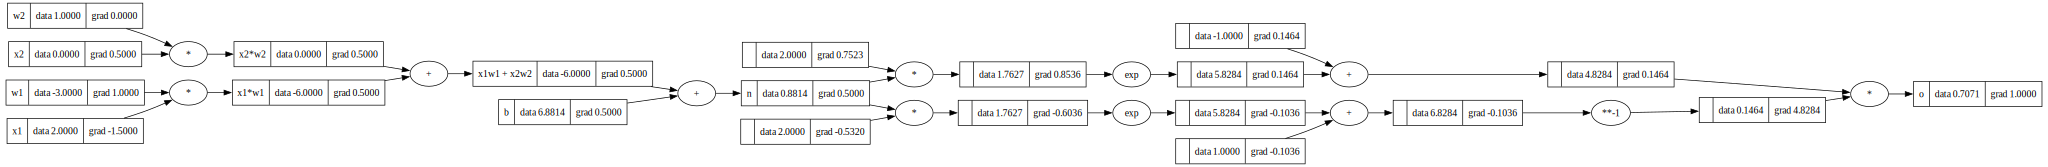

In [469]:
draw_dot(o)

Doing the same thing in pytorch:

In [470]:
#note, this stuff doesn't work on my windows pc due to AMD GPU
import torch

x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = (x1*w1) + (x2*w2) + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print(o)

0.7071066904050358
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)


In [471]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        #multiply weight by value (w * x) for each weight/value pair, and sum them up (with bias) resulting in an activation value
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        #pass activation value through a 'nonlinearity'
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)
print(n.w)
print(n.b)

[Value(data=0.17858751626974123)(label=), Value(data=0.7750452457522816)(label=)]
Value(data=0.779347378889282)(label=)
